# Simple forward simulation in phiflow

how to run ...
simple model equation 
$
    \frac{\partial u}{\partial{t}} + u \nabla u =
    \nu \nabla\cdot \nabla u
$ 

Note, the first command with a "!" prefix installs the [Φ<sub>Flow</sub> Python package from GitHub](https://github.com/tum-pbs/PhiFlow) via `pip` in your python environment. (Skip or modify this command if necessary.)

In [1]:
!pip install --upgrade --quiet phiflow
from phi.flow import *

# run with phiflow
n = 128
steps = 32
dt = 1./steps
viscosity = 0.01/np.pi
initial = np.asarray( [ [-math.sin(np.pi * x) * 1.] for x in np.linspace(-1,1,n)] )

domain = Domain([n], boundaries=PERIODIC, box=box[-1:1])
state = [BurgersVelocity(domain, velocity=initial, viscosity=viscosity)]

print("Note, the velocity array has a batch dimension, and 1 channel component in this 1D case: "+ format(state[0].velocity.data.shape) ) # -> (1, 128, 1)
print("\nInitial velocity state: " + format(state[0].velocity.data[0][0:5]) +" ..." )

for i in range(32):

    v = state[-1].velocity
    v = diffuse(v, dt * viscosity, substeps=1)
    v = advect.semi_lagrangian(v, v, dt)
    state.append( state[-1].copied_with(velocity=v, age=v.age + dt) )

    # here, we manually execute the different components of the PDE for clarity, 
    # in phiflow we could simply use the step() method of the Burgers() class:
    #state.append( Burgers().step(state[-1], dt=dt) )
    
print("\nLast velocity: " + format(state[-1].velocity.data[0][0:10]) +" ...")

Note, the velocity array has a batch dimension, and 1 channel component in this 1D case: (1, 128, 1)

Initial velocity state: [[1.2246469e-16]
 [4.9453720e-02]
 [9.8786421e-02]
 [1.4787737e-01]
 [1.9660644e-01]] ...

Last velocity: [[0.00552158]
 [0.0165598 ]
 [0.02760994]
 [0.03866227]
 [0.04973169]
 [0.06080895]
 [0.07190682]
 [0.08301631]
 [0.09414805]
 [0.10529345]] ...


/home/thuerey/anaconda3/envs/tf/lib/python3.8/_collections_abc.py:743: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for key in self._mapping:
/home/thuerey/anaconda3/envs/tf/lib/python3.8/_collections_abc.py:744: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  yield (key, self._mapping[key])
/home/thuerey/phiflow/phi/viz/display.py:80: UserWarning: GUI is disabled because of missing dependencies: No module named 'imageio'. To install all dependencies, run $ pip install phiflow[gui]
  warnings.warn('GUI is disabled because of missing dependencies: %s. To install all dependencies, run $ pip install phiflow[gui]' % import_error)


So far so good, but not so easy to evaluate. Show in graph: blue is initial state, then times $10/32, 20/32, 1$ in green, cyan and purple:

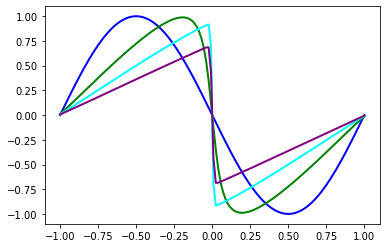

In [2]:
# we only need "velocity.data" from each phiflow state
vels = [x.velocity.data for x in state]

# print(vels[0][0,:,0].shape)
# print(vels[0].shape[1])

import matplotlib.pyplot as plt

fig = plt.figure().gca()
fig.plot(np.linspace(-1,1,len(vels[ 0].flatten())), vels[ 0].flatten(), lw=2, color='blue')
fig.plot(np.linspace(-1,1,len(vels[10].flatten())), vels[10].flatten(), lw=2, color='green')
fig.plot(np.linspace(-1,1,len(vels[20].flatten())), vels[20].flatten(), lw=2, color='cyan')
fig.plot(np.linspace(-1,1,len(vels[32].flatten())), vels[32].flatten(), lw=2, color='purple')


And as image...

Vels array shape: (1, 128, 33, 1)


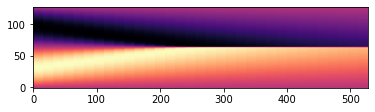

In [7]:
def show_state(a):
    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see
    # (could also be done with more evaluations of network)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=3)

    a = np.reshape( a, [a.shape[1],a.shape[2]*a.shape[3]] )
    #print("resulting image size" +format(a.shape))
    plt.imshow(a, origin='upper', cmap='magma')
    
vels_img = np.asarray( np.concatenate(vels, axis=-1), dtype=np.float32 )
vels_img = np.reshape(vels_img, list(vels_img.shape)+[1] ) ; print("Vels array shape: "+format(vels_img.shape))

# save for comparison with reconstructions later on
np.savez_compressed("./temp/burgers-groundtruth-solution.npz", np.reshape(vels_img,[n,steps+1])) # remove batch & channel dimension

show_state(vels_img)